In [1]:
from glob import glob
import os
import re
import sys
import random
import itertools
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import librosa
from tqdm.notebook import tqdm

In [2]:
TABLEU_COLOURS = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                  (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                  (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                  (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                  (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]) / 255

In [3]:
from meta_loader import get_meta, emotions

In [4]:
class EmotionCounter(Counter, OrderedDict):
    
    def __init__(self, *args):
        for e in emotions:
            self[e] = 0
        super(EmotionCounter, self).__init__(*args)        

In [5]:
def add_file_length(meta):
    new_meta = list()
    for m in tqdm(meta):
        f_name = m[0]
        t = 0
        try:
            if '.wav' in f_name:
                t = librosa.core.get_duration(filename=f_name)
            elif '.raw' in f_name:
                audio = np.fromfile(f_name, dtype=np.int16)
                t = len(audio) / 16000
            new_meta.append((*m, t))
            
        except:
            print(f'Error Loading {f_name}')
    return new_meta

In [6]:
def draw_polar_plot(counter, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(9, 9), subplot_kw=dict(polar=True))
    plt.title(title, fontsize=24)
    ticks = list(np.arange(0, 2 * np.pi, 2 * np.pi / len(counter))) + [0]
    counts = list(counter.values())
    ax.plot(ticks, counts + [counts[0]])
    ax.fill(ticks, counts + [counts[0]], alpha=0.2)
    # ax.set_xticklabels(e_counter.keys(), fontsize=18)
    ax.set_xticklabels(counter.keys(), fontsize=18)
    # plt.tight_layout()
    ax.set_rlabel_position(90)
    label = ax.get_xticklabels()
    for l in label:
        l.set_bbox(dict(facecolor='white', edgecolor='black')) 
    plt.show()
    
def draw_histogram_plot(counter, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(7, 8))
    plt.title(title, fontsize=18)
    plt.bar(counter.keys(), counter.values(), width=0.6)
    plt.show()

def draw_multi_histogram_plot(counters_and_labels, title='', sharey=False):
#     fig, axes = plt.subplots(len(counters_and_labels), 1,
#                              figsize=(8, 3 * len(counters_and_labels)),
#                              sharey=sharey)
    plt.subplots(1, 1, figsize=(6, 8))
    plt.title(title, fontsize=18)
    last_peaks = np.zeros_like(list(counters_and_labels[0][0].values()))
    for i, (counter, label) in enumerate(counters_and_labels):
#         x = np.arange(len(counter.keys()))
        plt.bar(counter.keys(), counter.values(), 
               alpha=0.8, width=0.6, label=label,
               bottom=last_peaks,
               color=TABLEU_COLOURS[i % len(TABLEU_COLOURS)])
        last_peaks += np.array(list(counter.values()))
#     ax.set_xticks(x)
#     ax.set_xticklabels(counter.keys())
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels), loc='upper right')
    plt.tight_layout()
    plt.show() 
    

In [7]:
dataset_keywords = ['ACRYL', 'CREMA-D', 'EMOV', 'ShEMO', 
                    'BAVED', 'ANAD', 'TESS', 'EEKK',
                    'JL-corpus', 'RAVDESS', 'VIVAE', 'URDU',   
                    'CaFE', 'AESDD', 'SAVEE']

In [8]:
meta = list(map(get_meta, dataset_keywords))

In [9]:
print('# Emtions')
print(emotions)
print()

filtered_meta = [list(filter(lambda x: x[2] in emotions, m)) for m in meta]
filtered_meta = list(map(add_file_length, filtered_meta))

print('# Meta data size')
for name, m, f_m in zip(dataset_keywords, meta, filtered_meta):
    print(f'{name:10}: {len(m):>5} > {len(f_m):>5}')
print(f'{"SUM":10}: {sum(map(len, meta)):>5} > {sum(map(len, filtered_meta)):>5}')    
      
# for m in meta:
#     print(random.choice(m))   

# meta_flat = list(itertools.chain.from_iterable(meta))
meta_flat = list(itertools.chain.from_iterable(filtered_meta))

# Emtions
['happiness', 'anger', 'neutral', 'sadness', 'disgust', 'fear', 'surprise', 'sleepy']



Error Loading Acted Emotional Speech Dynamic Database/sadness/s05 (3).wav




# Meta data size
ACRYL     : 22087 > 22087
CREMA-D   :  7442 >  7442
EMOV      :  6893 >  6893
ShEMO     :  3000 >  3000
BAVED     :  1935 >  1257
ANAD      :  1334 >  1334
TESS      :  2800 >  2800
EEKK      :  1164 >  1164
JL-corpus :  2400 >   960
RAVDESS   :  1440 >  1248
VIVAE     :  1085 >   900
URDU      :   400 >   400
CaFE      :   936 >   936
AESDD     :   605 >   604
SAVEE     :   480 >   480
SUM       : 54001 > 51505


In [10]:
# filtered_meta[1]

51505 Files


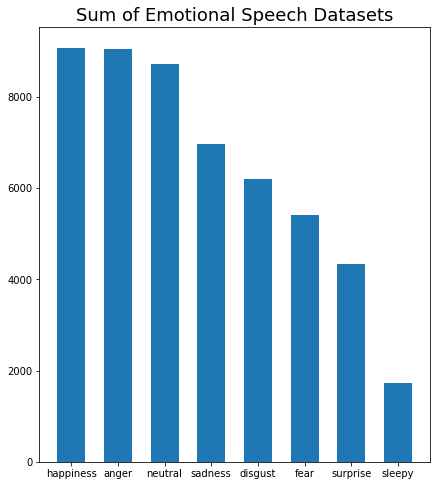

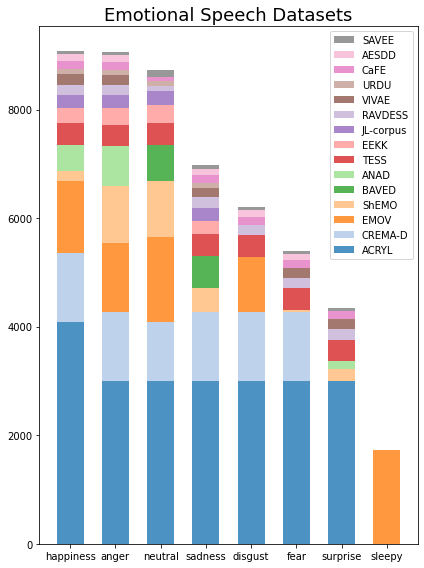

In [11]:
e_counter = EmotionCounter([e for f_name, s, e, t in meta_flat])

# print(e_counter)
print(f'{sum(e_counter.values())} Files')

# draw_polar_plot(e_counter, 'Total')
draw_histogram_plot(e_counter, 'Sum of Emotional Speech Datasets')

counters = list()
for name, m in zip(dataset_keywords, filtered_meta):
    e_counter = EmotionCounter([e for f_name, s, e, t in m])
    counters.append((e_counter, name))
    
draw_multi_histogram_plot(counters, 'Emotional Speech Datasets')
#     draw_histogram_plot(e_counter, name)

229952.42 Seconds
3832.54 Minutes
63.88 Hours


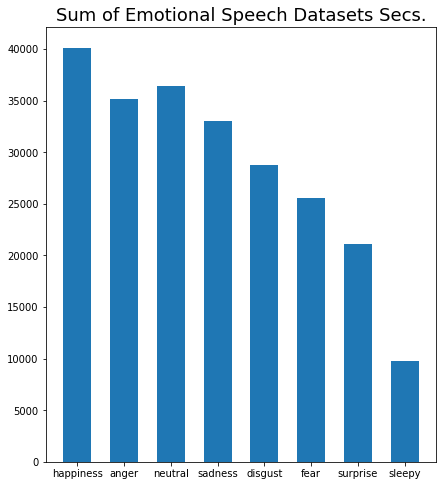

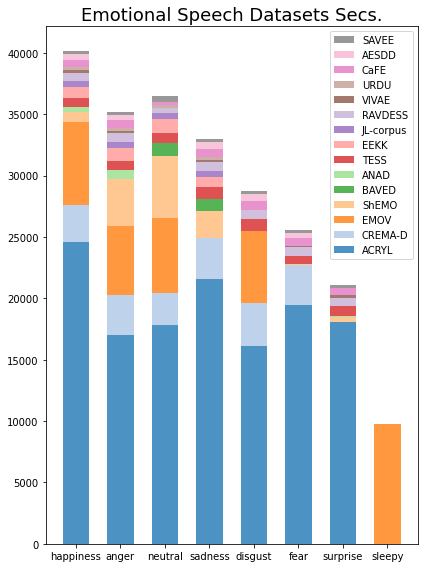

In [12]:
e_counter = EmotionCounter()
for f_name, s, e, t in meta_flat:
    e_counter[e] += t
# print(e_counter)

print(f'{sum(e_counter.values()):.2f} Seconds')
print(f'{sum(e_counter.values())/60:.2f} Minutes')
print(f'{sum(e_counter.values())/3600:.2f} Hours')

# draw_polar_plot(e_counter, 'Total')
draw_histogram_plot(e_counter, 'Sum of Emotional Speech Datasets Secs.')

counters = list()
for name, m in zip(dataset_keywords, filtered_meta):
    e_counter = EmotionCounter()
    for f_name, s, e, t in m:
        e_counter[e] += t
    counters.append((e_counter, name))
    
draw_multi_histogram_plot(counters, 'Emotional Speech Datasets Secs.')
#     draw_histogram_plot(e_counter, name)

In [13]:
fs_list = [[librosa.core.get_samplerate(m[0]) for m in meta 
            if '.wav' in m[0]] 
           for meta in filtered_meta]
    

In [14]:
for d, fs in zip(dataset_keywords, fs_list):
    c = Counter(fs)
    print(f'{d:10}|', c)

ACRYL     | Counter()
CREMA-D   | Counter({16000: 7442})
EMOV      | Counter({16000: 5106, 44100: 1787})
ShEMO     | Counter({44100: 2869, 22050: 131})
BAVED     | Counter({16000: 1257})
ANAD      | Counter({44100: 1334})
TESS      | Counter({24414: 2799, 96000: 1})
EEKK      | Counter({44100: 1164})
JL-corpus | Counter({44100: 960})
RAVDESS   | Counter({48000: 1248})
VIVAE     | Counter({44100: 900})
URDU      | Counter({44100: 400})
CaFE      | Counter({48000: 936})
AESDD     | Counter({44100: 604})
SAVEE     | Counter({44100: 480})


In [15]:
from scipy.io import wavfile

In [16]:
def convert_to_resampled_file(file):
    resampled_file = os.path.join('resampled', file).replace('.raw', '.wav')
    return resampled_file

In [17]:
def load_wav(file, save_resampled=True):
    
    resampled_file = convert_to_resampled_file(file)
    
    if os.path.isfile(resampled_file):
        y, fs = librosa.core.load(file, sr=None)
    else:
        if '.raw' in file:
            y = np.fromfile(file, dtype=np.int16)
            y = y / 2 ** 15

        elif '.wav' in file:

            y, fs = librosa.core.load(file, sr=None)

            if fs == 16000:
                return y
            elif fs % 16000 == 0:
                step = int(fs / 16000)
                offset = random.randint(0, step)
                return y[offset::step]
            else:
                y, fs = librosa.core.load(file, sr=16000)
        else: assert False, f'Invalid File Format {file}'
        
        if save_resampled:
            os.makedirs(os.path.dirname(resampled_file), exist_ok=True)
            int_y = (y * 2 ** 15).astype(np.int16)
            wavfile.write(resampled_file, 16000, y)
        
    return y

In [18]:
def split_meta(meta_list, ratio=0.05):
    
    num_test = int(len(meta_list) * ratio)
    
    random.shuffle(meta_list)
    
    meta_valid = sorted(meta_list[:num_test])
    meta_train = sorted(meta_list[num_test:])
    
    return meta_train, meta_valid

In [19]:
meta_train = list()
meta_valid = list()

for m in filtered_meta:
    train, valid = split_meta(m)
    meta_train.append(train)
    meta_valid.append(valid)

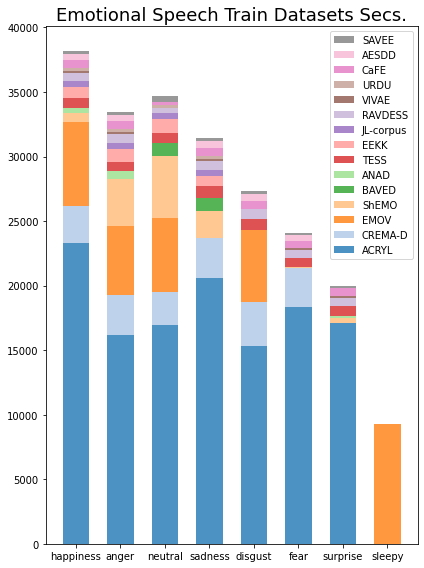

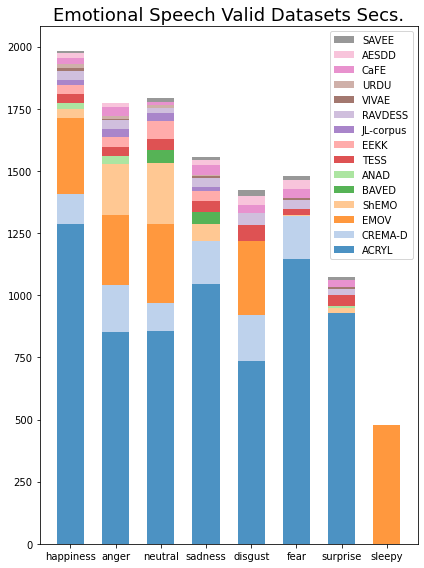

In [20]:
counters = list()
for name, m in zip(dataset_keywords, meta_train):
    e_counter = EmotionCounter()
    for f_name, s, e, t in m:
        e_counter[e] += t
    counters.append((e_counter, name))
    
draw_multi_histogram_plot(counters, 'Emotional Speech Train Datasets Secs.')

counters = list()
for name, m in zip(dataset_keywords, meta_valid):
    e_counter = EmotionCounter()
    for f_name, s, e, t in m:
        e_counter[e] += t
    counters.append((e_counter, name))
    
draw_multi_histogram_plot(counters, 'Emotional Speech Valid Datasets Secs.')

In [21]:
# 51505/51505 [25:01<00:00, 34.30it/s]
# [load_wav(m[0]) for m in tqdm(meta_flat)]